# Neural Fine Gray on FRAMINGHAM Dataset

In this notebook, we will apply Neural Fine Gray on the FRAMINGHAM data.

In [2]:
import sys
sys.path.append('../')
sys.path.append('../DeepSurvivalMachines/')

In [8]:
# count nans in df 
df


,eid,event,duration,feature_0_x,feature_1_x,feature_2_x,feature_3_x,feature_4_x,feature_5_x,feature_6_x,...,feature_130_y,feature_131_y,feature_132_y,feature_133_y,feature_134_y,feature_135_y,feature_136_y,feature_137_y,feature_138_y,feature_139_y
0,1007079,1,1137.000001,0.026490,-0.057304,0.091047,-0.071039,-0.002189,-0.010172,0.015391,...,-2.144796e+09,4.047213e+08,1.800831e+08,1.015033e+08,-2.241062e+07,2.117400e+06,1.224840e+07,50359.697438,-5.106233e+05,-693320.977778
1,1009041,2,304.000001,-0.000312,-0.059861,0.111449,-0.074401,-0.019056,-0.011975,0.025685,...,3.006820e+08,-4.674909e+08,1.425908e+08,2.347890e+08,-2.961656e+07,1.962509e+06,-6.204858e+06,-596936.092263,-4.416941e+05,933147.815189
2,1009727,1,367.000001,0.005949,-0.062669,0.087096,-0.071220,-0.003094,-0.021868,0.018319,...,-2.044829e+09,-3.366616e+08,1.526802e+08,-5.707337e+06,6.438846e+06,4.586807e+05,-8.749103e+05,-272271.237490,-3.799527e+05,252318.400209
3,1013241,1,1154.000001,0.011002,-0.042266,0.104070,-0.061743,-0.012246,-0.012669,0.024986,...,1.052476e+09,-4.186003e+08,-2.734863e+08,3.395242e+07,3.070348e+06,-5.085408e+06,6.044268e+06,-51800.347840,-1.069043e+06,-291383.489665
4,1013997,1,592.000001,0.016536,-0.059973,0.095931,-0.082984,-0.013993,-0.013447,0.027269,...,-1.874540e+09,-3.711567e+08,4.791157e+07,-3.777207e+07,6.390919e+06,-1.000346e+06,-2.674996e+06,-140699.953998,4.777805e+04,309017.699526


In [7]:
import pandas as pd

EPS = 1e-6
df = pd.read_csv("/home/dmitrii/GitHub/CompetingRisk/data/competing_risk/abdomen_3m_unspec_2_features.csv")
# rename column time_to_event to duration
df = df.rename(columns={"time_to_event": "duration"})
split_cols = [f"split_{i}" for i in range(5)] 
df = df.drop(columns=split_cols)
df['duration'] += EPS
df_rad = pd.read_csv("/home/dmitrii/GitHub/CompetingRisk/data/competing_risk/abdomen_3m_unspec_2_pca_10_features.csv")
# rename column time_to_event to duration
split_cols = [f"split_{i}" for i in range(5)] 
cols_to_remove = split_cols + ['time_to_event'] + ["event"]
df_rad = df_rad.drop(columns=cols_to_remove)
df = df.merge(df_rad, on = 'eid')

### Load the FRAMINGHAM Dataset

The package includes helper functions to load the dataset.

X represents an np.array of features (covariates),
T is the event/censoring times and,
E is the censoring indicator.

In [2]:
from nfg import datasets
x, t, e, columns = datasets.load_dataset('FRAMINGHAM', path = '../', competing = True)

In [2]:
from nfg import datasets
x, t, e, columns = datasets.load_dataset('ABDOMEN_RADIOMICS', path = '../', competing = True)

In [3]:
from nfg import datasets
x, t, e, columns = datasets.load_dataset('CARDIAC_EMBEDDINGS', path = '../', competing = True)

In [4]:
# unique values of e (numpy array)
import numpy as np
print(np.unique(e))


[0 1 2 3]


In [5]:
x.shape

(2495, 1025)

array(['SEX', 'CURSMOKE', 'DIABETES', 'BPMEDS', 'educ', 'PREVCHD',
       'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TOTCHOL', 'AGE',
       'SYSBP', 'DIABP', 'CIGPDAY', 'BMI', 'HEARTRTE', 'GLUCOSE'],
      dtype=object)

In [5]:
x.shape, t.shape, e.shape

((3162, 1025), (3162,), (3162,))

### Compute horizons at which we evaluate the performance of Neural Fine Gray

Survival predictions are issued at certain time horizons. Here we will evaluate the performance
of NFG to issue predictions at the 25th, 50th and 75th event time quantile as is standard practice in Survival Analysis.

In [6]:
import numpy as np
import torch
np.random.seed(42)
torch.random.manual_seed(42)

horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e > 0], horizons) # Fixed horizons for accurate comparison between competing and non competing

(array([220., 240., 334., 558., 416., 250., 165., 108., 150.,  54.]),
 array([  90.00000001,  379.20000001,  668.40000001,  957.60000001,
        1246.80000001, 1536.00000001, 1825.20000001, 2114.40000001,
        2403.60000001, 2692.80000001, 2982.00000001]),
 <BarContainer object of 10 artists>)

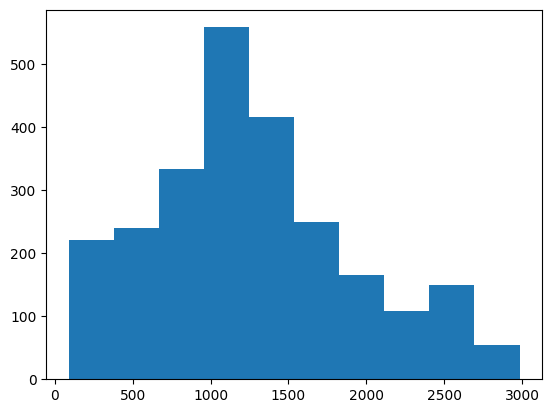

In [7]:
import matplotlib.pyplot as plt
plt.hist(t)

In [8]:
# Display the percentage of observed event at different time horizon
for time in times:
    print('At time {:.2f}'.format(time))
    for risk in np.unique(e):
        print('\t {:.2f} % observed risk {}'.format(100 * ((e == risk) & (t < time)).mean(), risk))

print('Total')
for risk in np.unique(e):
    print('\t {:.2f} % observed risk {}'.format(100 * ((e == risk)).mean(), risk))

At time 596.00
	 0.60 % observed risk 0
	 4.09 % observed risk 1
	 1.60 % observed risk 2
	 9.34 % observed risk 3
At time 1023.50
	 7.82 % observed risk 0
	 8.22 % observed risk 1
	 3.33 % observed risk 2
	 18.56 % observed risk 3
At time 1504.50
	 24.65 % observed risk 0
	 11.78 % observed risk 1
	 4.61 % observed risk 2
	 28.74 % observed risk 3
Total
	 39.80 % observed risk 0
	 15.07 % observed risk 1
	 5.81 % observed risk 2
	 39.32 % observed risk 3


### Splitting the data into train, test and validation sets

We will train NFG on 80% of the Data (10 % of which is used for stopping criterion and 10% for model Selection) and report performance on the remaining 20% held out test set.

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size = 0.2, random_state = 42)
x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x_train, t_train, e_train, test_size = 0.2, random_state = 42)
#x_dev, t_dev, e_dev = x_val.copy(), t_val.copy(), e_val.copy()
x_dev, x_val, t_dev, t_val, e_dev, e_val = train_test_split(x_val, t_val, e_val, test_size = 0.5, random_state = 42)

### Setting the parameter grid

As a constrained neural network, training is sensitive to the hyperparameters, we recommend a grid search as followed:

In [10]:
from sklearn.model_selection import ParameterSampler

In [11]:
layers = [[50], [50, 50], [50, 50, 50], [100], [100, 100], [100, 100, 100]]
param_grid = {
            'learning_rate' : [1e-3, 1e-4],
            'layers_surv': layers,
            'layers' : layers,
            'batch': [100, 250],
            }
params = ParameterSampler(param_grid, 5, random_state = 42)

### Model Training and Selection

In [12]:
from nfg import NeuralFineGray

In [13]:
import torch 
torch.cuda.is_available() > 0

True

In [14]:
models = []
for param in params:
    model = NeuralFineGray(layers = param['layers'], layers_surv = param['layers_surv'])
    # The fit method is called to train the model
    model.fit(x_train, t_train, e_train, n_iter = 1000, bs = param['batch'],
            lr = param['learning_rate'], val_data = (x_dev, t_dev, e_dev))
    nll = model.compute_nll(x_val, t_val, e_val)
    if not(np.isnan(nll)):
        models.append([nll, model])
    else:
        print("WARNING: Nan Value Observed")

Loss: 1.418:  17%|█▋        | 171/1000 [02:07<10:20,  1.34it/s]


In [15]:
best_model = min(models, key = lambda x: x[0])
model = best_model[1]

### Inference

Model prediction for the different patients and analysis of the results. As we use cumulative metrics, we predict over a grid of points.

In [16]:
pred_times = np.linspace(0, t_train.max(), 100)
out_survival = model.predict_survival(x_test, pred_times.tolist())
out_risk = 1 - out_survival

### Evaluation

We evaluate the performance of NFG in its discriminative ability (Time Dependent Concordance Index and Cumulative Dynamic AUC) as well as Brier Score. Note that we implemented competing risks metrics.

In [17]:
from metrics import truncated_concordance_td, auc_td, brier_score

In [18]:
cis, brs, rocs = [], [], []
km = (e_train, t_train)
for i, te in enumerate(times):
    # Compute metrics for risk = 1 and estimate the km used for IPCW
    ci, km = truncated_concordance_td(e_test, t_test, out_risk, pred_times, te, km = km, competing_risk = 1) 
    cis.append(ci)
    brs.append(brier_score(e_test, t_test, out_risk, pred_times, te, km = km, competing_risk = 1)[0])
    rocs.append(auc_td(e_test, t_test, out_risk, pred_times, te, km = km, competing_risk = 1)[0])

for i, horizon in enumerate(horizons):
    print(f"For {horizon} quantile,")
    print("Truncated Concordance Index: {:.3f}".format(cis[i]))
    print("tdAUC: {:.3f}".format(rocs[i]))
    print("Brier Score: {:.3f}".format(brs[i]))
    print('*' * 50)

For 0.25 quantile,
Truncated Concordance Index: 0.467
tdAUC: 0.463
Brier Score: 0.026
**************************************************
For 0.5 quantile,
Truncated Concordance Index: 0.406
tdAUC: 0.404
Brier Score: 0.073
**************************************************
For 0.75 quantile,
Truncated Concordance Index: 0.474
tdAUC: 0.494
Brier Score: 0.119
**************************************************


In [21]:
cis, brs, rocs = [], [], []
km = (e_train, t_train)
for i, te in enumerate(times):
    # Compute metrics for risk = 1 and estimate the km used for IPCW
    ci, km = truncated_concordance_td(e_test, t_test, out_risk, pred_times, te, km = km, competing_risk = 1) 
    cis.append(ci)
    brs.append(brier_score(e_test, t_test, out_risk, pred_times, te, km = km, competing_risk = 1)[0])
    rocs.append(auc_td(e_test, t_test, out_risk, pred_times, te, km = km, competing_risk = 1)[0])

for i, horizon in enumerate(horizons):
    print(f"For {horizon} quantile,")
    print("Truncated Concordance Index: {:.3f}".format(cis[i]))
    print("tdAUC: {:.3f}".format(rocs[i]))
    print("Brier Score: {:.3f}".format(brs[i]))
    print('*' * 50)

For 0.25 quantile,
Truncated Concordance Index: 0.569
tdAUC: 0.576
Brier Score: 0.106
**************************************************
For 0.5 quantile,
Truncated Concordance Index: 0.548
tdAUC: 0.550
Brier Score: 0.185
**************************************************
For 0.75 quantile,
Truncated Concordance Index: 0.538
tdAUC: 0.538
Brier Score: 0.258
**************************************************


In [21]:
out_risk.shape, durations_test.shape, events_test.shape

NameError: name 'durations_test' is not defined

In [20]:
# transpose out_risk 
out_risk = out_risk.T
out_risk.shape

(100, 633)

In [22]:
# out_risk of shape (887, 100) to dataframe matrix with columns rows 100 and columns 887
import pandas as pd
surv = pd.DataFrame(out_risk)
surv.shape

(100, 633)

In [41]:
events_test

array([0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 0, 1, 0, 0, 1,
       0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2,
       0, 1, 2, 0, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 1, 0, 0, 2, 1, 1, 0,
       0, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 1,
       0, 2, 0, 0, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0,
       0, 2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 2, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 0, 2,
       2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 1, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1,
       0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2,

In [25]:
from pycox.evaluation import EvalSurv
durations_test = t_test
events_test = e_test
num_risks = 1
time_grid = pred_times


#surv = model.predict_surv_df(x_test)
#surv = out_risk
ev_test = EvalSurv(surv, durations_test, events_test == 2, censor_surv="km")
overall_c_index = ev_test.concordance_td()
print(f"Overall C-index: {overall_c_index:.4f}")

# Per-event evaluation using cumulative incidence functions (CIF)
#cif = model.predict_cif(x_test)  # List of arrays (one per risk)
#cif = out_risk
#event_metrics = {}
#for i in range(num_risks):
#    #cif_i = pd.DataFrame(cif[i], model.duration_index)
#    cif_i = out_risk
#    ev_event = EvalSurv(1 - cif_i, durations_test, events_test == (i+1), censor_surv="km")
#    event_c_index = ev_event.concordance_td()
#    #time_grid = np.linspace(0, durations_test.max(), best_params["num_durations"])
    
#    event_ibs = ev_event.integrated_brier_score(time_grid)
#    event_metrics[f"event_{i+1}"] = {"c_index": event_c_index, "ibs": event_ibs}

#metrics = {"overall_c_index": overall_c_index, "event_metrics": event_metrics}

Overall C-index: 0.4496
